# Convolutional Neural Networks


Convolutional Neural Networks (CNNs) are modifications to the original FFN design, while traditionally FFNs will take in all features to be processed, CNNs can restrict the amount of features that are processed at one time through the use of a spatial (or temporal) kernel. 

For 1D CNNs, for instance audio, you'll apply the same set of CNN filters at each of the timesteps of the audio. CNNs have a kernel size, which allow them to take neighboring datapoints into account when they are applied. Similarly for 2D CNNs, this means applying the same CNN filters to each pixel of the image. 2D kernels will take surrounding pixels (horizontal and vertical) into input as well.

CNNs are better able to deal with sequences of data, in the sense that convolutions can allow the network to take information along a sequence into account, and through stacking CNNs with elements like max pooling eventually be able to have access to the entire sequence into context.

#### Overview of a 1D CNN module.

![](images/conv1d.png)

Here a 2 channel, kernel-size 3, CNN is applied to an input of batch size 4, channel size 3, and length 4. First padding elements (grey) are added to the input, and we apply the CNN (center) to each of the timesteps of the input. The process shown for our first segment is shown in blue, and is repeated across all timesteps to build our complete output. 

For normal 1D CNNs all channels in the input are used for a given timestep, and the number of input channels must be specified, this is why our CNN consists of a width of 2 (for output channels), height of 4 (for our input channels), and length of 3 (for our kernel width).


# Components of a CNN system

## CNN Kernel Size

Like FFNs, CNNs have a set of weights that can be updated and used to learn the task at hand. 1D CNNs are applied, similarly to FFNs, across all input features (in the case of a text classification task, this usually means the embedding dimension of your text). Unlike FFNs, however, CNNs have a 'width' to them which corresponds to their kernel-size. For the same type of a problem, a CNN with kernel size, $k$, will have $k \times$ as many weights as a FFN being applied to the same task, thus it is somewhat more computationally complex. 

Because kernels are generally centered at a time step, odd number sizes of kernels ($3$, $5$, and $7$ are common values) are used to ensure that the convolution is not lopsided.

Let's look at how to setup a basic CNN and experiment with different kernel sizes:

In [13]:
import torch, torchtext
from torch import nn, Tensor

print("CNN input/output dimensions:[N,C,L] --> N (Batch), C (Channel), L (Length)")
input_size = 3
number_of_cnn_filters = 5 # number of channels in the output

example_cnn_kernel3 = nn.Conv1d(input_size,number_of_cnn_filters,3)
x = torch.randn(2,3,5)


print("With a size 3 kernel")
print("Input tensor has shape: {}".format(x.shape))
out = example_cnn_kernel3(x)
print("Output tensor has shape: {}".format(out.shape))

example_cnn_kernel5 = nn.Conv1d(input_size,number_of_cnn_filters,5)

print("With a size 5 kernel")
print("Input tensor has shape: {}".format(x.shape))
out = example_cnn_kernel5(x)
print("Output tensor has shape: {}".format(out.shape))


CNN input/output dimensions:[N,C,L] --> N (Batch), C (Channel), L (Length)
With a size 3 kernel
Input tensor has shape: torch.Size([2, 3, 5])
Output tensor has shape: torch.Size([2, 5, 3])
With a size 5 kernel
Input tensor has shape: torch.Size([2, 3, 5])
Output tensor has shape: torch.Size([2, 5, 1])


In our both cases the Batch dimension (usually written as $N$) doesn't change, but our channel dimension ($C$, and usually corresponding to the hidden $H$ or embedding $E$ dimension in other layers), is set to the number of CNN filters in our layer (1 filter = 1 output channel). The last dimension, our length $L$ dimension, however, decreases depending on our kernel size. (You can experiment with this yourself, what happens if you set the kernel size > the length?)  

## Padding

To account for differences in input size, and allow for consistent sizes as data is passed through a CNN model, padding, $0$ valued cells, can be added to the front and the back of the input. This allows a CNN to apply to the very first value in an input sequence, without shortening the output length. For simple models (with odd-number kernel sizes), picking a padding size, $p$, such that $p = \frac{k - 1}{2}$ can ensure a consistent size through a CNN layer.

In [14]:
print("CNN input/output dimensions:[N,C,L] --> N (Batch), C (Channel), L (Length)")

input_size = 3
number_of_cnn_filters = 5 # number of channels in the output

example_cnn_with_padding = nn.Conv1d(input_size,number_of_cnn_filters,5, padding =2)
x = torch.randn(2,3,5)

print("With a size 5 kernel and padding = 2")
print("Input tensor has shape: {}".format(x.shape))
out = example_cnn_with_padding(x)
print("Output tensor has shape: {}".format(out.shape))


CNN input/output dimensions:[N,C,L] --> N (Batch), C (Channel), L (Length)
With a size 5 kernel and padding = 2
Input tensor has shape: torch.Size([2, 3, 5])
Output tensor has shape: torch.Size([2, 5, 5])


## Pooling

Finally, while a kernel size of the CNN allows for the model to learn spatial or temporal aspects of the input, often time for convenience a layer is added to the model to take a only a portion of 'most useful' samples from one layer of the model to the next. One way to do this is through a *Max Pooling* layer, which chunks up data, and only passes the largest value in each chunk to the next layer. This is an easy way to dramatically decrease the size of the input from one layer to the next, speeding up processing time while further highlighting the most important features in the data. Similarly, *Average Pooling* can be used to take the average of a chunk of data.

In [16]:
print("CNN input/output dimensions:[N,C,L] --> N (Batch), C (Channel), L (Length)")

input_size = 3
number_of_cnn_filters = 5 # number of channels in the output

example_cnn_with_padding = nn.Conv1d(input_size,number_of_cnn_filters,3, padding =1)
example_max_pool = nn.MaxPool1d(2)  # Pooling Kernel = 2 means we HALVE the length
x = torch.randn(2,3,20)

print("With a size 5 kernel and padding = 2")
print("Input tensor has shape: {}".format(x.shape))
out = example_cnn_with_padding(x)
print("Output tensor from CNN has shape: {}".format(out.shape))
out = example_max_pool(out)
print("Output tensor from Pooling has shape: {}".format(out.shape))

CNN input/output dimensions:[N,C,L] --> N (Batch), C (Channel), L (Length)
With a size 5 kernel and padding = 2
Input tensor has shape: torch.Size([2, 3, 20])
Output tensor from CNN has shape: torch.Size([2, 5, 20])
Output tensor from Pooling has shape: torch.Size([2, 5, 10])


Finally a handy variant of normal max pooling is AdaptivePooling, which can be used to compress an input into a fixed number of outputs, regardless of what the input length is. This is handy at the end of a model to shrink all the timesteps down to a single point (which can then be fed to a linear layer to project to your output classfication).

In [21]:
print("CNN input/output dimensions:[N,C,L] --> N (Batch), C (Channel), L (Length)")

input_size = 3
number_of_cnn_filters = 5 # number of channels in the output

example_cnn_with_padding = nn.Conv1d(input_size,number_of_cnn_filters,3, padding =1)
example_adaptive_pool = nn.AdaptiveMaxPool1d(1)  # Squish into one timestep, taking highest value for each channel.
x = torch.randn(2,3,20)

print("With a size 5 kernel and padding = 2")
print("Input tensor has shape: {}".format(x.shape))
out = example_cnn_with_padding(x)
print("Output tensor from CNN has shape: {}".format(out.shape))
out = example_adaptive_pool(out)
print("Output tensor from Pooling has shape: {}".format(out.shape))

out = out.squeeze()
print("Final size after dropping L dimension: {}".format(out.shape))

CNN input/output dimensions:[N,C,L] --> N (Batch), C (Channel), L (Length)
With a size 5 kernel and padding = 2
Input tensor has shape: torch.Size([2, 3, 20])
Output tensor from CNN has shape: torch.Size([2, 5, 20])
Output tensor from Pooling has shape: torch.Size([2, 5, 1])
Final size after dropping L dimension: torch.Size([2, 5])


# Classification Task Movie Reviews

With the basics of these CNN layers, we can tackle a slightly more complex challenge compared to the single sentence classification task. In this task, we'll use the CNN to capture meaning across a length of tokens in our input paragraph. We'll be looking at IMDB movie reviews, again classifying into positive and negative examples.

In [26]:
import torch, torchtext
from torch import nn, Tensor
from torchtext.datasets import IMDB
from torchtext.data import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.utils.data import dataset, random_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Now let's get our dataset:

In [27]:
IMDB_train = IMDB(split="train")
IMDB_train = to_map_style_dataset(IMDB_train)
IMDB_train, IMDB_dev = random_split(IMDB_train, [15000,10000])


To look at an example:

In [29]:
for i in IMDB_train:
    print(i)
    break

('pos', 'This is a very funny movie, easy to watch, that entertains you almost all the time. The work of the Director is recognizable and the type of humor is his trademark. The movie is a typical police partners history like lethal weapon, but the jokes and comedy are of Argentinian sort. The twist is that one of them is a psychologist played by Peretti and has to go with detective Diaz (played by Luque) on his assignments while he also assist him (Diaz is troubled because his wife cheated on him). Some of the dialogs are hilarious worldwide: understandable and laughable anywhere. Is very good overall, it would deserved an 8, but I rated 7 because it gets a little down at the end. On a personal remark I must add that is a "bravo" for Argentinian Filmmakers, considering the little good is coming lately.')


Let's get the vocabulary of our train set, that way we can easily assign tokens to IDs and vice versa.

In [31]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(lambda x: tokenizer(x[1]), IMDB_train), min_freq=5, specials=['<unk>','<pad>'])
vocab.set_default_index(vocab['<unk>'])

We want to break the full sentence into individual word tokens, and get them in a format our model can handle, here is a basic way to do it:

In [32]:
from typing import List, Optional, Any, Union

class default_tokenizer(nn.Module):
    def __init__(self, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer

    def forward(self, input: Any) -> Any:
        if torch.jit.isinstance(input, List[str]):
            tokens: List[List[str]] = []
            for text in input:
                tokens.append(self.tokenizer(text))
            return tokens
        elif torch.jit.isinstance(input, str):
            return self.tokenizer(input)
        else:
            raise TypeError("Input type not supported")
         

In [33]:
len(vocab)

23317

For our text processing, we will use torchtext's Transforms to apply the tokenization and mapping to ID in sequence.

In [41]:
import torchtext.transforms as T

processor = T.Sequential(
    default_tokenizer(tokenizer),
    T.VocabTransform(vocab),
    )
label_processor = T.LabelToIndex(['pos','neg'] )

In [42]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_processor(_label))
        processed_text = torch.tensor(processor(_text))
        text_list.append(processed_text)
    return torch.tensor(label_list), pad_sequence(text_list, padding_value=vocab.__getitem__("<pad>"))


train_dataloader = DataLoader(list(IMDB_train), batch_size=16, shuffle=True, 
                              collate_fn=collate_batch)
dev_dataloader = DataLoader(list(IMDB_dev), batch_size=16, shuffle=False, 
                              collate_fn=collate_batch)

Let's look at what a processed example looks like. Note the padding (token ID=1) in our second tensor. While our Labels are just a 1d tensor, our input text is a 2D tensor, with dimensions [L,N] (length corresponding to rows, batch corresponding to columns (so one sentence per column from top to bottom), this is why there are so many 1s towards the bottom rows of the tensor, they are all the padded parts of the short sentences.

In [43]:
for i in train_dataloader:
    print(i)
    break

(tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]), tensor([[  14,  263,  107,  ..., 1755, 1322,   13],
        [  52,   72,   23,  ...,   76,    0,   96],
        [   2,  115,   69,  ...,    8,   52,    9],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]]))


Let's re-use our training code from earlier:

In [44]:
from sklearn.metrics import accuracy_score 

def train(loader, model, criterion, optimizer, device):
    total_loss = 0.0
    num_sample = 0
    for batch in loader:
        # load the current batch
        batch_output, batch_input = batch  #unpack the batch

        batch_input = batch_input.to(device)
        batch_output = batch_output.to(device)
        # forward propagation
        # pass the data through the model
        model_outputs = model(batch_input)
        # compute the loss
        cur_loss = criterion(model_outputs, batch_output)
        total_loss += cur_loss.item()

        # backward propagation (compute the gradients and update the model)
        # clear the buffer
        optimizer.zero_grad()
        # compute the gradients
        cur_loss.backward()
        # update the weights
        optimizer.step()
        num_sample += batch_output.shape[0]
    return total_loss / num_sample


# evaluation logic based on classification accuracy
def evaluate(loader, model, device):
    all_pred = []
    all_label = []
    with torch.no_grad():
        for batch in loader:
            # load the current batch
            batch_output, batch_input = batch

            batch_input = batch_input.to(device)
            # forward propagation
            # pass the data through the model
            model_outputs = model(batch_input)
            # identify the predicted class for each example in the batch
            probabilities, predicted = torch.max(model_outputs.cpu().data, 1)
            # put all the true labels and predictions to two lists
            all_pred.extend(predicted)
            all_label.extend(batch_output)

    accuracy = accuracy_score(all_label, all_pred)
    return accuracy


Our model definition. I also make some helper functions (PermuteModule and SqueezeModule) to make the forward pass simple. These helper modules just apply their respective functions when they are chained in the ModuleList.

In [45]:
## HELPER MODULES
class PermuteModule(nn.Module):
    ## APPLY PERMUTE WHEN USED IN A MODULELIST
    def __init__(self, dims):
        super(PermuteModule, self).__init__()
        self.dims = dims
    def forward(self, x):
        return torch.permute(x, self.dims)

class SqueezeModule(nn.Module):
    ## APPLY SQUEEZE WHEN USED IN A MODULELIST
    def __init__(self, dims=None):
        super(SqueezeModule, self).__init__()
    
    def forward(self, x):
        return x.squeeze()
    
    
class ConvNet(nn.Module):
    def __init__(self, output_size, layers, channels, kernel_size, vocab_size, embedding_size, dropout):
        super(ConvNet, self).__init__()
        '''
        output_size: Number of classes in a classification task
        layers: How many CNN layers to apply
        channels: Number of filters for each CNN to use
        kernel_size: width of the 1 Dimensional CNN kernel (each channel will take in this much width when creating an output point)
        vocab_size: the number of tokens in our vocabulary
        embedding_size: the number of dimensions to represent each token
        dropout: regularization probability.
        '''        
        
        self.layers = nn.ModuleList()  # Keep track of our layers
        self.nonlinear = nn.ReLU()     # Non-linear activation 
        self.dropout = nn.Dropout(p=dropout)     #  Dropout helps the network generalize to unseen data
        self.pooling = nn.MaxPool1d(kernel_size=2)   # Our pooling operation, here we divide the length in half each time.
        self.layers.append(PermuteModule((1,0)))
        self.layers.append(nn.Embedding(vocab_size, embedding_size, padding_idx=vocab.__getitem__("<pad>")))  # Convert input vocab indices to vectors (doesn't compress L dimension like EmbeddingBag)
        self.layers.append(PermuteModule((0,2,1)))

        self.layers.append(nn.Conv1d(embedding_size, channels, kernel_size))   #  Basic CNN 
        self.layers.append(self.nonlinear)
        for layer in range(layers):    # For each layer, add a Linear, nonlinear activation, and dropout.
            self.layers.append(nn.Conv1d(channels, channels, kernel_size))
            self.layers.append(self.nonlinear)
            self.layers.append(self.pooling)
            self.layers.append(self.dropout)
        self.layers.append(nn.AdaptiveMaxPool1d(1))   # Collapse the time dimension
        self.layers.append(SqueezeModule())   # get rid of collapsed dimension
        self.layers.append(nn.Linear(channels, output_size))  # Project to output size
        self.layers.append(nn.Softmax(dim=-1))   # Softmax normalizes vectors so they can represent probabilities
    
    def forward(self, x):    # out 'foward' pass, since we put everything into a ModuleList, we just iterate it.
        for layer in self.layers:
            x = layer(x)
        return x

In [47]:
model = ConvNet(2, 2, 128, 3, len(vocab), 128, .3)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criteria = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
max_epochs = 30


Before we train, let's look a little bit more at our model:

In [49]:
print("The entire model looks like this: ")
print(model)
print("If we just wanted to look at the ModuleList, we could just print it out as well (these are the sequence of layers) ")
print(model.layers)

The entire model looks like this: 
ConvNet(
  (layers): ModuleList(
    (0): PermuteModule()
    (1): Embedding(23317, 128, padding_idx=1)
    (2): PermuteModule()
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.3, inplace=False)
    (9): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.3, inplace=False)
    (13): AdaptiveMaxPool1d(output_size=1)
    (14): SqueezeModule()
    (15): Linear(in_features=128, out_features=2, bias=True)
    (16): Softmax(dim=-1)
  )
  (nonlinear): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (pooling): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
If we just wanted to look at the ModuleList, we could

In [50]:

results = {"epoch": [], "loss" : [], "train acc" : [], "val acc" :[]}
for i in range(max_epochs):
    loss = train(train_dataloader, model, criteria, optimizer, device)
    train_acc = evaluate(train_dataloader, model, device)
    val_acc = evaluate(dev_dataloader, model, device)
    results["epoch"].append(i)
    results["loss"].append(loss)
    results['train acc'].append(train_acc)
    results['val acc'].append(val_acc)
    
    print("Epoch {} results: Loss {}, Train Acc: {}, Val Acc: {}".format(i+1, loss, train_acc, val_acc))


Epoch 1 results: Loss 0.04337153381506602, Train Acc: 0.5020666666666667, Val Acc: 0.5033
Epoch 2 results: Loss 0.043280045413970944, Train Acc: 0.5516666666666666, Val Acc: 0.5586
Epoch 3 results: Loss 0.04310861246188482, Train Acc: 0.5213333333333333, Val Acc: 0.5224
Epoch 4 results: Loss 0.04258451509078344, Train Acc: 0.592, Val Acc: 0.593
Epoch 5 results: Loss 0.041469856758912405, Train Acc: 0.6276666666666667, Val Acc: 0.6254
Epoch 6 results: Loss 0.03934925354917844, Train Acc: 0.709, Val Acc: 0.7011
Epoch 7 results: Loss 0.03698840180635452, Train Acc: 0.7215333333333334, Val Acc: 0.7134
Epoch 8 results: Loss 0.035994927604993184, Train Acc: 0.7342666666666666, Val Acc: 0.7187
Epoch 9 results: Loss 0.03508005459507307, Train Acc: 0.7388666666666667, Val Acc: 0.7189
Epoch 10 results: Loss 0.03448299227754275, Train Acc: 0.7713333333333333, Val Acc: 0.7372
Epoch 11 results: Loss 0.033710312559207284, Train Acc: 0.7625333333333333, Val Acc: 0.7306
Epoch 12 results: Loss 0.032913

In [51]:
import matplotlib.pyplot as plt
import numpy as np

Let's plot our results!

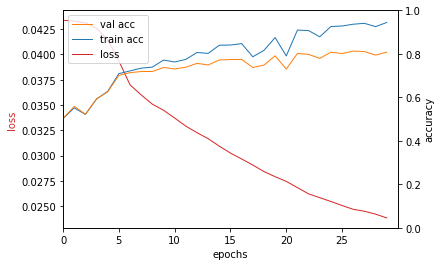

In [54]:
fig, ax1 = plt.subplots()

color = 'tab:red'
loss_line, = ax1.plot(results["epoch"],results["loss"], linewidth=1.0, color=color, label= "loss")
ax1.set(xlim=(0, 30), xticks=np.arange(0, 30,5))                               
ax1.set_ylabel('loss', color=color)                             
ax1.set_xlabel('epochs')
ax2 = ax1.twinx()


train_line, = ax2.plot(results["epoch"],results["train acc"], linewidth=1.0, label='train acc')
val_line, = ax2.plot(results["epoch"],results["val acc"], linewidth=1.0, label='val acc')
ax2.set(xlim=(0, 30), xticks=np.arange(0, 30,5),
       ylim=(0, 1))
ax2.set_ylabel('accuracy')

p = [val_line, train_line, loss_line]
ax2.legend(p, [p_.get_label() for p_ in p])

plt.show()